In [1]:
import pandas as pd
import yaml
from matplotlib import pyplot as plt
from datetime import datetime as dt

config file

In [2]:
with open("..\\budget_book\config.ini", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

clm = cfg['column names database']

read historic stock prices

In [3]:
stockdata = pd.read_csv( 'stockdata.csv', encoding = 'ISO-8859-1' )

# stockdata["Date"] = pd.to_datetime( stockdata["Date"] , format = '%Y-%m-%d' )
stockdata["Date"] = pd.to_datetime( stockdata["Date"] , format = cfg['date format'] )
stockdata.set_index("Date", inplace=True)

stockdata.head()

,IE00B57X3V84,WSRUS.MI
Date,,
2023-01-02,NaN,21.295
2023-01-03,48.886866,20.910
2023-01-04,49.896393,20.910
2023-01-05,48.980021,20.910
2023-01-06,50.094003,20.910


1 year performance

In [4]:
(stockdata.iloc[-1] / stockdata[stockdata.index >= dt(dt.today().year - 1 , dt.today().month , dt.today().day)].iloc[0] - 1)*100

IE00B57X3V84    9.456126
WSRUS.MI        7.824271
dtype: float64

In [5]:
stocks = list(stockdata.columns)

get stock transactions

In [14]:
file = "..\\budget_book\\" + cfg['CSV filenames']['database']  + ".csv"
transactions = pd.read_csv( file, encoding = 'ISO-8859-1' )

transactions = transactions[transactions[clm["text"]].str.contains('|'.join(stocks)).fillna(False) ]

transactions[clm['date']] = pd.to_datetime( transactions[clm['date']] , format = cfg['date format'] )
transactions.set_index(clm["date"], inplace=True)

transactions.drop([clm["balance"], clm["category"]], axis = 1, inplace=True)

transactions[clm["amount"]] = - transactions[clm["amount"]]

transactions.head(15)

,amount,description
date,,
2023-12-01,200.0,IE00B57X3V84
2023-11-01,200.0,IE00B57X3V84
2023-10-02,200.0,IE00B57X3V84
2023-09-01,200.0,IE00B57X3V84
2023-08-01,200.0,IE00B57X3V84
2023-07-03,200.0,IE00B57X3V84
2023-06-01,200.0,IE00B57X3V84
2023-05-01,200.0,IE00B57X3V84
2023-04-03,200.0,IE00B57X3V84


subtract fee

In [7]:
def fee(x):
    return x - 4.9

calculate total invested money & aquired shares

In [8]:
shares = transactions.join(stockdata).sort_index()

transactions_columns = [(column, ''       ) for column in transactions.columns]
share_columns        = [(stock , 'price €') for stock  in stocks              ]
shares.columns = pd.MultiIndex.from_tuples(transactions_columns + share_columns)

for stock in stocks:
    shares[(stock, 'invest €')] = shares[clm["text"]].str.contains(stock) * shares[clm["amount"]]
    shares[(stock, 'invest €')] = shares[(stock, 'invest €')].cumsum()

    shares[(stock, 'shares'  )] = shares[clm["text"]].str.contains(stock) * shares[clm["amount"]].map(fee) / shares[(stock, 'price €')]
    shares[(stock, 'shares'  )] = shares[(stock, 'shares')].cumsum()

shares.drop(share_columns + transactions_columns, axis = 1, inplace=True)

shares = shares.reindex(sorted(shares.columns), axis=1)

shares.tail(15)

IE00B57X3V84            WSRUS.MI           
               invest €     shares invest €     shares
date                                                  
2023-01-03        200.0   3.990847      0.0   0.000000
2023-02-01        400.0   7.792032      0.0   0.000000
2023-03-01        600.0  11.604045      0.0   0.000000
2023-03-13        600.0  11.604045   1000.0  44.275861
2023-04-03        800.0  15.322039   1000.0  44.275861
2023-05-01       1000.0  19.074404   1000.0  44.275861
2023-06-01       1200.0  22.643125   1000.0  44.275861
2023-07-03       1400.0  26.150136   1000.0  44.275861
2023-08-01       1600.0  29.584792   1000.0  44.275861
2023-09-01       1800.0  33.029972   1000.0  44.275861
2023-10-02       2000.0  36.535249   1000.0  44.275861
2023-11-01       2200.0  40.102759   1000.0  44.275861
2023-12-01       2400.0  43.464633   1000.0  44.275861

filter time

In [9]:
# stockdata = stockdata[stockdata.index > dt(dt.today().year - 1 , dt.today().month , 1) ]
stockdata = stockdata[stockdata.index >= transactions.index[-1] ]

join stock prices & shares

In [10]:
stockdata.columns = pd.MultiIndex.from_tuples(share_columns)

data = stockdata.join(shares.resample('1D').mean(numeric_only=True).interpolate(method='pad')).interpolate(method='pad')

calculate value, profit, performance

In [11]:
for stock in stocks:
    data[(stock, 'value €') ] =  data[(stock, 'price €')] * data[(stock, 'shares')]
    data[(stock, 'profit €')] =  data[(stock, 'value €')] - data[(stock, 'invest €')]

data[('all', 'invest €') ] =  data.xs('invest €', axis=1, level=1).sum(axis=1)
data[('all', 'value €' ) ] =  data.xs('value €' , axis=1, level=1).sum(axis=1)
data[('all', 'profit €') ] =  data.xs('profit €', axis=1, level=1).sum(axis=1)

shares_columns = [(stock, 'shares') for stock  in stocks]
data.drop(share_columns + shares_columns, axis = 1, inplace=True)

data = data.reindex(sorted(data.columns), axis=1)

data.tail()

IE00B57X3V84                          WSRUS.MI               
               invest €    profit €      value € invest €    profit €   
Date                                                                    
2023-12-25       2400.0  176.825244  2576.825244   1000.0  143.055164  \
2023-12-26       2400.0  186.256637  2586.256637   1000.0  142.022065   
2023-12-27       2400.0  188.864500  2588.864500   1000.0  140.988966   
2023-12-28       2400.0  177.482103  2577.482103   1000.0  140.988966   
2023-12-29       2400.0  190.436276  2590.436276   1000.0  140.988966   

                             all                           
                value € invest €    profit €      value €  
Date                                                       
2023-12-25  1143.055164   3400.0  319.880408  3719.880408  
2023-12-26  1142.022065   3400.0  328.278702  3728.278702  
2023-12-27  1140.988966   3400.0  329.853467  3729.853467  
2023-12-28  1140.988966   3400.0  318.471070  3718.471070  
2023-12-29  1140.988966   3400.0  331.425242  3731.425242

plot

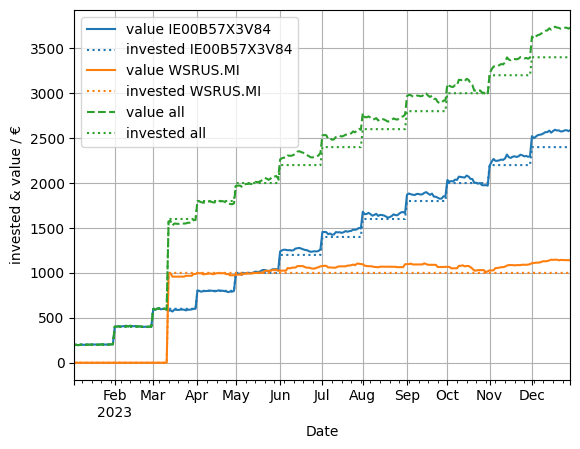

In [12]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig,ax = plt.subplots(1)
for i, stock in enumerate(stocks):
    data[(stock, 'value €') ].plot(label='value '    + stock, color=colors[i])
    data[(stock, 'invest €')].plot(label='invested ' + stock, color=colors[i]  , linestyle=':' )
data[('all', 'value €' )    ].plot(label='value all'   ,      color=colors[i+1], linestyle='--')
data[('all', 'invest €')    ].plot(label='invested all',      color=colors[i+1], linestyle=':' )
plt.grid()
plt.ylabel('invested & value / €')
plt.legend()
# ax.set_yticklabels([])

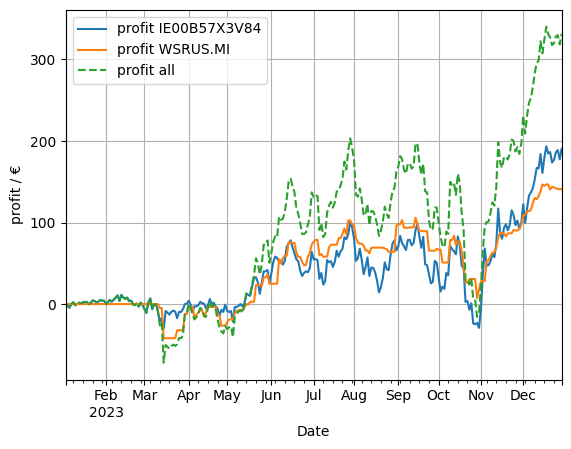

In [13]:
for stock in stocks:
    data[(stock, 'profit €')].plot(label='profit ' + stock)
data[('all', 'profit €')    ].plot(label='profit all', linestyle='--')
plt.grid()
plt.ylabel('profit / €')
plt.legend()